In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns #for plotting
from sklearn.ensemble import RandomForestClassifier #for the model
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz #plot tree
from sklearn.metrics import roc_curve, auc #for model evaluation
from sklearn.metrics import classification_report #for model evaluation
from sklearn.metrics import confusion_matrix #for model evaluation
from sklearn.model_selection import train_test_split #for data splitting
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.pipeline import make_pipeline
import eli5 #for purmutation importance
from eli5.sklearn import PermutationImportance
import shap #for SHAP values
#from pdpbox import pdp, info_plots #for partial plots
np.random.seed(123) #ensure reproducibility

pd.options.mode.chained_assignment = None  #hide any pandas warnings

In [2]:
from platform import python_version
print(python_version())

3.9.7


In [145]:
#import the dataframe for train, test
df = pd.read_excel('aug10.xlsx')

In [146]:
#dataframe for search 
aim = pd.read_excel('freq.xlsx')

In [121]:
df.head()

,单位,体检编号,体检次数,体检流水号_x,姓名_x,性别_x,年龄_x,电话,体检日期,25羟维生素D,...,入院日期,出院日期,入院诊断,出院诊断,出院医嘱,年龄_y,性别_y,姓名_y.1,身份证,体检流水号_y
0,个人套餐,141166,1,710150025,刘艳玲,女,26.0,13725290942,2007-10-15 11:06:56.627,NaN,...,2022-01-02,2022-01-07,右髌骨骨折,右髌骨骨折,NaN,Y43,男,梁尤键,450104197605151538,1603030018
1,个人套餐,141666,1,710170030,李小慰,女,23.0,NaN,2007-10-17 10:19:23.087,NaN,...,2022-02-25,2022-02-28,1.左侧输尿管下段结石并左肾积液 2.左肾结石,1.左侧输尿管下段结石并左肾积液 2.左侧输尿管狭窄 3.双肾小结石 4.泌尿道感染 5.高...,NaN,Y50,男,孙英杰,150402197010210618,1310300016
2,个人套餐,141666,1,710170030,李小慰,女,23.0,NaN,2007-10-17 10:19:23.087,NaN,...,2022-02-25,2022-02-28,1.左侧输尿管下段结石并左肾积液 2.左肾结石,1.左侧输尿管下段结石并左肾积液 2.左侧输尿管狭窄 3.双肾小结石 4.泌尿道感染 5.高...,NaN,Y50,男,孙英杰,150402197010210618,1504280095
3,个人套餐,141666,1,710170030,李小慰,女,23.0,NaN,2007-10-17 10:19:23.087,NaN,...,2022-02-25,2022-02-28,1.左侧输尿管下段结石并左肾积液 2.左肾结石,1.左侧输尿管下段结石并左肾积液 2.左侧输尿管狭窄 3.双肾小结石 4.泌尿道感染 5.高...,NaN,Y50,男,孙英杰,150402197010210618,1606250119
4,个人套餐,141666,1,710170030,李小慰,女,23.0,NaN,2007-10-17 10:19:23.087,NaN,...,2018-12-17,2018-12-22,1.结肠息肉 2.慢性胃炎 3.脂肪肝 4.高尿酸血症 5.高脂血症,1.结肠多发性息肉 2.慢性胃炎 3.脂肪肝 4.高尿酸血症 5.高脂血症,NaN,Y47,男,孙英杰,150402197010210618,1310300016


In [122]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2866 entries, 0 to 2865
Columns: 163 entries, 单位 to 体检流水号_y
dtypes: datetime64[ns](4), float64(105), int64(10), object(44)
memory usage: 3.6+ MB


In [123]:
aim.head()

,诊断,频数
0,高尿酸血症,369
1,脂肪肝,316
2,高脂血症,284
3,2型糖尿病,238
4,低蛋白血症,175


In [124]:
# 选择整数类型的列
int_cols = df.select_dtypes(include=['int']).columns.tolist()

# 打印结果
print(int_cols)

['体检编号', '体检次数', '体检流水号_x', '体检年', '出生年', 'INP_NO', 'ID_NO', 'SECRET_LEVEL', '身份证', '体检流水号_y']


In [125]:
# 选择小数类型的列
float_cols = df.select_dtypes(include=['float']).columns.tolist()

# 打印结果
print(float_cols)

['年龄_x', '25羟维生素D', 'C反应蛋白', 'C反应蛋白1', '癌抗原125', '癌抗原125（CA125）', '癌抗原15－3', '癌抗原15-3（CA15-3）', '癌胚抗原', '癌胚抗原（CEA）定性', '白/球比值(A/G)', '白蛋白(ALB)', '丙氨酸氨基转移酶(ALT)', '低密度脂蛋白(LDL)', '恶性肿瘤生长因子(TSGF)', '二氧化碳结合力(CO2-CP)', '腹围', '甘油三脂(TG)', '高密度脂蛋白(HDL)', '谷氨酰转肽酶(γ-GT)', '骨钙素(BGP)', '肌酐(Cr)', '肌酸激酶(CK)', '肌酸激酶同工酶', '肌酸激酶同功酶(CK-Mb（M）)', '甲胎蛋白', '甲胎蛋白1', '甲胎蛋白（AFP）定性', '甲状旁腺素(PTH)', '碱性磷酸酶(AKP)', '结合型前列腺特异性抗原', '结合型前列腺特异性抗原C-PSA', '空腹血糖', '空腹胰岛素', '鳞状细胞癌抗原', '鳞状细胞癌抗原1', '鳞状细胞癌抗原测定scc', '尿酸(UA)', '球蛋白(GLB)', '人绒毛促性腺激素（Beta-HCG）', '人绒毛膜促性腺激素', '乳酸脱氢酶(LDH)', '神经元特异性烯醇化酶', '神经原特异性烯醇化酶（NSE）', '双能骨密度检测', '双能骨密度检测1', '糖链抗原（CA242）', '糖链抗原19-9', '糖链抗原242', '糖链抗原-242', '体重', '天门冬丙氨酸氨基转移酶(AST)', '胃癌抗原', '细胞角蛋白19片段', '细胞角蛋白19片段(Cy)', '细胞角蛋白19片段（CY211）', '血糖(空腹)', '腰围', '胰岛素', '胰岛素1', '载脂蛋白AI(APO-A1)', '载脂蛋白B(ApoB)', '肿瘤标志物相关物质（TSGF）', '肿瘤抗原19-9', '肿瘤抗原242', '肿瘤抗原CA-125', '肿瘤抗原CA-153', '总胆固醇(CHOL)', '总胆红素(TBIL)', '总胆汁酸', '总胆汁酸(TBA)', '总蛋白(TP)', 'NAME_PHONETIC', 'IDENTITY', 'UNIT_IN_CONTRACT', 'NEXT_OF_KIN_ZIP

In [126]:
df['出院诊断'].isnull().sum()

0

In [155]:
# 搜索 '高尿酸血症' 是否在 '出院诊断' 列中，并添加新列 'target'
df['target'] = df['出院诊断'].apply(lambda x: 1 if '高尿酸血症' in x else 0)

In [156]:
#检查数据平衡性
df['target'].value_counts()

0    2448
1     418
Name: target, dtype: int64

In [132]:
# 使用 rename() 方法重命名列
df = df.rename(columns={'年龄_x': '入院年龄'})

In [141]:
print(df['入院日期'].dtype)

object


In [142]:
print(df['体检年'].dtype)

int64


In [148]:
# 计算每个列的非空值比例
nonnull_ratio = df.notnull().sum() / len(df)

# 选择非空值比例超过 20% 的浮点类型列
float_cols = df.columns[(df.dtypes == 'float64') & (nonnull_ratio > 0.2)]

# 打印结果
print(float_cols)

Index(['年龄_x', '丙氨酸氨基转移酶(ALT)', '低密度脂蛋白(LDL)', '甘油三脂(TG)', '高密度脂蛋白(HDL)',
       '肌酐(Cr)', '尿酸(UA)', '天门冬丙氨酸氨基转移酶(AST)', '总胆固醇(CHOL)', 'HOME_ZIP'],
      dtype='object')


In [149]:
# Remove '年龄_x' and 'HOME_ZIP' from float_cols
float_cols = float_cols.drop(['年龄_x', 'HOME_ZIP'])

In [150]:
# 打印结果
print(float_cols)

Index(['丙氨酸氨基转移酶(ALT)', '低密度脂蛋白(LDL)', '甘油三脂(TG)', '高密度脂蛋白(HDL)', '肌酐(Cr)',
       '尿酸(UA)', '天门冬丙氨酸氨基转移酶(AST)', '总胆固醇(CHOL)'],
      dtype='object')


In [151]:
#input
X = df[float_cols]

In [157]:
#output
y = df['target']

In [158]:
X.shape

(2866, 8)

In [159]:
y.shape

(2866,)

In [160]:
X.isna().sum()

丙氨酸氨基转移酶(ALT)        283
低密度脂蛋白(LDL)         1827
甘油三脂(TG)            1563
高密度脂蛋白(HDL)         2250
肌酐(Cr)              1169
尿酸(UA)              1628
天门冬丙氨酸氨基转移酶(AST)     664
总胆固醇(CHOL)          1573
dtype: int64

In [161]:
df_dummy = pd.get_dummies(X)
df_dummy.dtypes

丙氨酸氨基转移酶(ALT)       float64
低密度脂蛋白(LDL)         float64
甘油三脂(TG)            float64
高密度脂蛋白(HDL)         float64
肌酐(Cr)              float64
尿酸(UA)              float64
天门冬丙氨酸氨基转移酶(AST)    float64
总胆固醇(CHOL)          float64
dtype: object

In [162]:
#使用knn填补缺失数据
imputer = KNNImputer(missing_values=np.nan)
df_dummy_knn = pd.DataFrame(imputer.fit_transform(df_dummy), columns=df_dummy.columns)
df_dummy_knn

,丙氨酸氨基转移酶(ALT),低密度脂蛋白(LDL),甘油三脂(TG),高密度脂蛋白(HDL),肌酐(Cr),尿酸(UA),天门冬丙氨酸氨基转移酶(AST),总胆固醇(CHOL)
0,20.988386,3.607834,1.568557,1.388669,83.479906,346.339984,22.965486,5.144656
1,13.000000,3.390000,1.340000,1.332000,91.360000,381.520000,45.000000,5.936000
2,13.000000,3.390000,1.340000,1.332000,91.360000,381.520000,45.000000,5.936000
3,13.000000,3.390000,1.340000,1.332000,91.360000,381.520000,45.000000,5.936000
4,13.000000,3.390000,1.340000,1.332000,91.360000,381.520000,45.000000,5.936000
...,...,...,...,...,...,...,...,...
2861,38.000000,3.680000,2.710000,1.760000,74.000000,347.000000,25.000000,6.450000
2862,16.000000,3.770000,1.130000,1.640000,93.000000,357.000000,19.000000,6.590000
2863,15.000000,2.580000,0.830000,1.150000,80.000000,296.000000,21.600000,4.640000
2864,44.000000,2.830000,3.500000,1.680000,112.000000,686.000000,21.000000,4.920000


In [163]:
df_dummy_knn.isnull().sum()

丙氨酸氨基转移酶(ALT)       0
低密度脂蛋白(LDL)         0
甘油三脂(TG)            0
高密度脂蛋白(HDL)         0
肌酐(Cr)              0
尿酸(UA)              0
天门冬丙氨酸氨基转移酶(AST)    0
总胆固醇(CHOL)          0
dtype: int64

# 填补后数据 vs 填补前

In [164]:
df[float_cols].describe()

,丙氨酸氨基转移酶(ALT),低密度脂蛋白(LDL),甘油三脂(TG),高密度脂蛋白(HDL),肌酐(Cr),尿酸(UA),天门冬丙氨酸氨基转移酶(AST),总胆固醇(CHOL)
count,2583.000000,1039.000000,1303.000000,616.000000,1697.000000,1238.000000,2202.000000,1293.000000
mean,20.988386,3.607834,1.568557,1.388669,83.479906,346.339984,22.965486,5.144656
std,21.247679,8.751723,1.258682,0.274052,19.140982,100.134474,11.747405,0.897811
min,2.000000,0.740000,0.310000,0.780000,32.000000,127.700000,1.000000,2.270000
25%,11.000000,2.400000,0.850000,1.200000,67.000000,273.000000,17.000000,4.590000
50%,16.000000,2.970000,1.320000,1.400000,83.000000,340.000000,22.000000,5.090000
75%,23.000000,3.405000,1.900000,1.550000,98.000000,398.750000,27.000000,5.620000
max,521.000000,143.100000,25.650000,2.490000,139.100000,818.000000,286.000000,8.560000


In [165]:
df_dummy_knn.describe()

,丙氨酸氨基转移酶(ALT),低密度脂蛋白(LDL),甘油三脂(TG),高密度脂蛋白(HDL),肌酐(Cr),尿酸(UA),天门冬丙氨酸氨基转移酶(AST),总胆固醇(CHOL)
count,2866.000000,2866.000000,2866.000000,2866.000000,2866.000000,2866.000000,2866.000000,2866.000000
mean,20.930151,3.632869,1.529481,1.387581,83.217606,342.029650,23.058938,5.106201
std,20.193557,6.629141,0.992743,0.177747,16.531327,82.454617,10.535880,0.727530
min,2.000000,0.740000,0.310000,0.780000,32.000000,127.700000,1.000000,2.270000
25%,12.000000,2.538000,0.956000,1.306000,72.000000,287.540000,18.000000,4.670500
50%,17.000000,2.938000,1.342000,1.388669,83.479906,342.900000,22.965486,5.100000
75%,23.000000,3.398000,1.708000,1.454000,93.400000,383.925000,26.000000,5.400000
max,521.000000,143.100000,25.650000,2.490000,139.100000,818.000000,286.000000,8.560000


In [166]:
df_dummy_knn.describe().index

Index(['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'], dtype='object')

In [167]:
df_dummy_knn.columns

Index(['丙氨酸氨基转移酶(ALT)', '低密度脂蛋白(LDL)', '甘油三脂(TG)', '高密度脂蛋白(HDL)', '肌酐(Cr)',
       '尿酸(UA)', '天门冬丙氨酸氨基转移酶(AST)', '总胆固醇(CHOL)'],
      dtype='object')

In [168]:
df.columns

Index(['单位', '体检编号', '体检次数', '体检流水号_x', '姓名_x', '性别_x', '年龄_x', '电话', '体检日期',
       '25羟维生素D',
       ...
       '出院日期', '入院诊断', '出院诊断', '出院医嘱', '年龄_y', '性别_y', '姓名_y.1', '身份证',
       '体检流水号_y', 'target'],
      dtype='object', length=164)

Glyph 19993 missing from current font.
Glyph 27688 missing from current font.
Glyph 37240 missing from current font.
Glyph 22522 missing from current font.
Glyph 36716 missing from current font.
Glyph 31227 missing from current font.
Glyph 37238 missing from current font.
Glyph 19993 missing from current font.
Glyph 27688 missing from current font.
Glyph 37240 missing from current font.
Glyph 22522 missing from current font.
Glyph 36716 missing from current font.
Glyph 31227 missing from current font.
Glyph 37238 missing from current font.


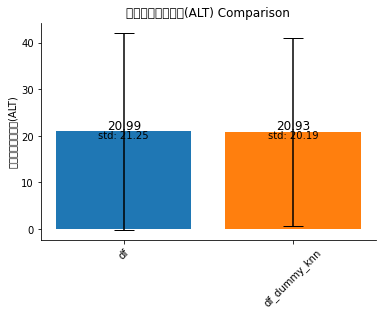

Glyph 20302 missing from current font.
Glyph 23494 missing from current font.
Glyph 24230 missing from current font.
Glyph 33026 missing from current font.
Glyph 34507 missing from current font.
Glyph 30333 missing from current font.
Glyph 20302 missing from current font.
Glyph 23494 missing from current font.
Glyph 24230 missing from current font.
Glyph 33026 missing from current font.
Glyph 34507 missing from current font.
Glyph 30333 missing from current font.


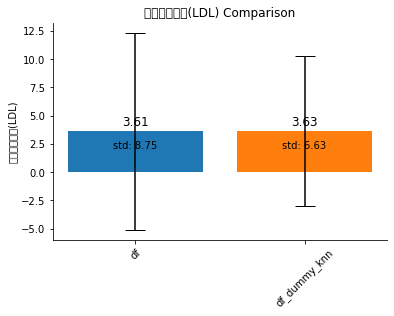

Glyph 29976 missing from current font.
Glyph 27833 missing from current font.
Glyph 19977 missing from current font.
Glyph 29976 missing from current font.
Glyph 27833 missing from current font.
Glyph 19977 missing from current font.


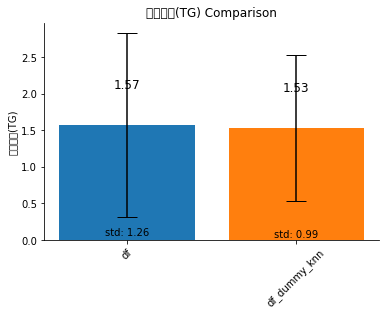

Glyph 39640 missing from current font.
Glyph 39640 missing from current font.


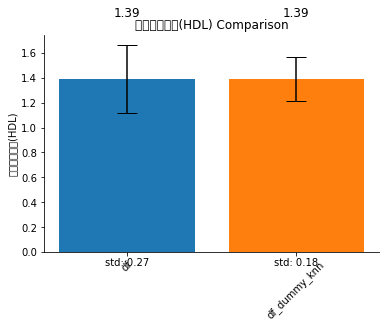

Glyph 32908 missing from current font.
Glyph 37200 missing from current font.
Glyph 32908 missing from current font.
Glyph 37200 missing from current font.


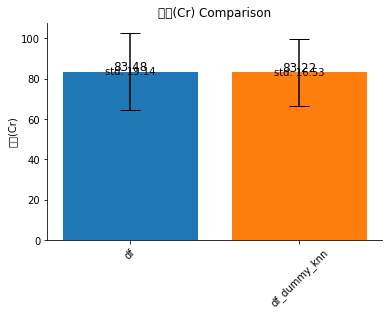

Glyph 23615 missing from current font.
Glyph 23615 missing from current font.


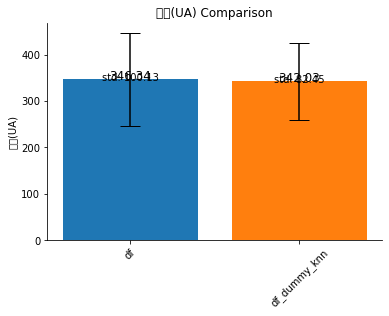

Glyph 22825 missing from current font.
Glyph 38376 missing from current font.
Glyph 20908 missing from current font.
Glyph 22825 missing from current font.
Glyph 38376 missing from current font.
Glyph 20908 missing from current font.


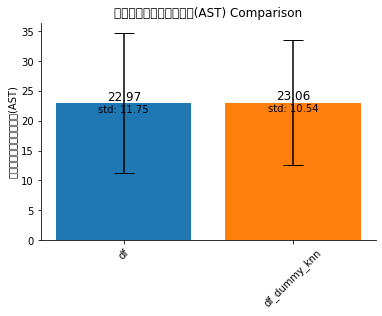

Glyph 24635 missing from current font.
Glyph 32966 missing from current font.
Glyph 22266 missing from current font.
Glyph 37255 missing from current font.
Glyph 24635 missing from current font.
Glyph 32966 missing from current font.
Glyph 22266 missing from current font.
Glyph 37255 missing from current font.


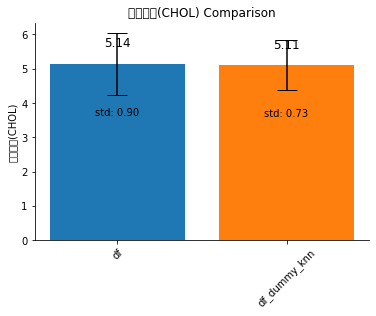

In [169]:
# Calculate summary statistics
df_dummy_knn_stats = df_dummy_knn.describe()
df_stats = df[float_cols].describe()

# Define custom colors for bars
colors = ['#1f77b4', '#ff7f0e']
# Create bar plots of summary statistics
for col in df_stats.columns:
    fig, ax = plt.subplots()
    ax.bar(['df', 'df_dummy_knn'], [df_stats[col]['mean'], df_dummy_knn_stats[col]['mean']], yerr=[df_stats[col]['std'], df_dummy_knn_stats[col]['std']], capsize=10, color=colors)
    ax.set_ylabel(col)
    ax.set_title(f'{col} Comparison')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # Add labels for mean and std
    ax.text(0, df_stats[col]['mean']+0.5, f"{df_stats[col]['mean']:.2f}", ha='center', fontsize=12)
    ax.text(1, df_dummy_knn_stats[col]['mean']+0.5, f"{df_dummy_knn_stats[col]['mean']:.2f}", ha='center', fontsize=12)
    ax.text(0, df_stats[col]['mean']-1.5, f"std: {df_stats[col]['std']:.2f}", ha='center', fontsize=10)
    ax.text(1, df_dummy_knn_stats[col]['mean']-1.5, f"std: {df_dummy_knn_stats[col]['std']:.2f}", ha='center', fontsize=10)
    plt.xticks(rotation=45)
    plt.show()

In [170]:
#split into training and testing data
X_train, X_test, y_train, y_test = train_test_split(df_dummy_knn, y, test_size = .2, random_state=10)
X_train

,丙氨酸氨基转移酶(ALT),低密度脂蛋白(LDL),甘油三脂(TG),高密度脂蛋白(HDL),肌酐(Cr),尿酸(UA),天门冬丙氨酸氨基转移酶(AST),总胆固醇(CHOL)
778,20.988386,3.607834,1.568557,1.388669,83.479906,346.339984,22.965486,5.144656
1740,18.000000,2.250000,3.936000,1.110000,103.000000,311.800000,12.000000,4.392000
2248,49.000000,3.080000,3.750000,1.522000,102.000000,411.000000,28.000000,8.050000
1338,20.000000,3.510000,0.960000,1.454000,88.000000,350.000000,24.000000,5.310000
2332,14.000000,2.340000,0.530000,1.890000,62.000000,326.000000,25.000000,4.760000
...,...,...,...,...,...,...,...,...
2009,18.000000,3.398000,1.470000,1.454000,113.000000,516.000000,24.000000,5.230000
1180,15.000000,2.068000,0.670000,1.454000,65.000000,285.000000,25.000000,5.360000
1344,8.000000,2.776000,1.322000,1.186000,86.000000,289.260000,24.200000,5.094000
527,13.000000,2.658000,1.376000,1.450000,93.400000,316.140000,21.000000,5.140000


In [171]:
y_train.value_counts()

0    1949
1     343
Name: target, dtype: int64

In [172]:
y_test.value_counts()

0    499
1     75
Name: target, dtype: int64

Glyph 19993 missing from current font.
Glyph 27688 missing from current font.
Glyph 37240 missing from current font.
Glyph 22522 missing from current font.
Glyph 36716 missing from current font.
Glyph 31227 missing from current font.
Glyph 37238 missing from current font.
Glyph 19993 missing from current font.
Glyph 27688 missing from current font.
Glyph 37240 missing from current font.
Glyph 22522 missing from current font.
Glyph 36716 missing from current font.
Glyph 31227 missing from current font.
Glyph 37238 missing from current font.


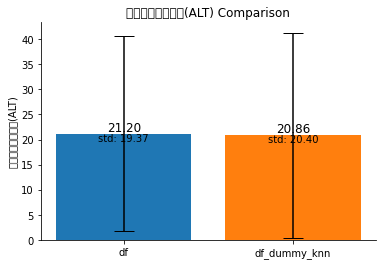

Glyph 20302 missing from current font.
Glyph 23494 missing from current font.
Glyph 24230 missing from current font.
Glyph 33026 missing from current font.
Glyph 34507 missing from current font.
Glyph 30333 missing from current font.
Glyph 20302 missing from current font.
Glyph 23494 missing from current font.
Glyph 24230 missing from current font.
Glyph 33026 missing from current font.
Glyph 34507 missing from current font.
Glyph 30333 missing from current font.


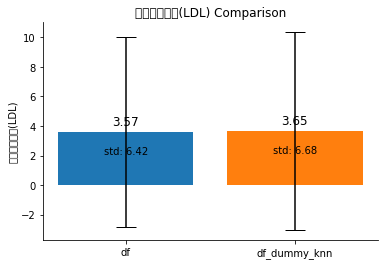

Glyph 29976 missing from current font.
Glyph 27833 missing from current font.
Glyph 19977 missing from current font.
Glyph 29976 missing from current font.
Glyph 27833 missing from current font.
Glyph 19977 missing from current font.


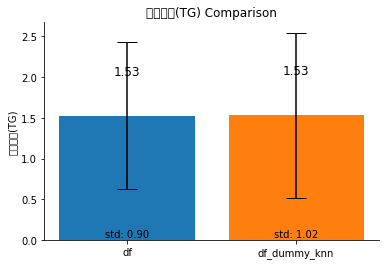

Glyph 39640 missing from current font.
Glyph 39640 missing from current font.


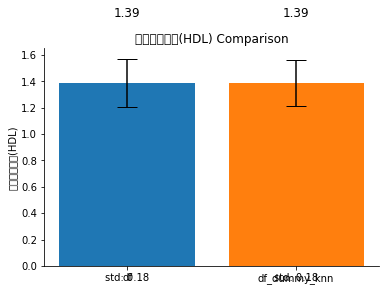

Glyph 32908 missing from current font.
Glyph 37200 missing from current font.
Glyph 32908 missing from current font.
Glyph 37200 missing from current font.


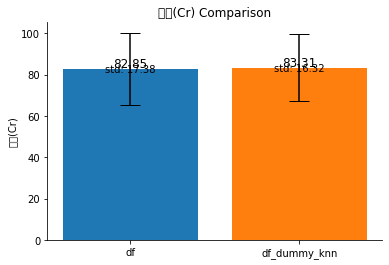

Glyph 23615 missing from current font.
Glyph 23615 missing from current font.


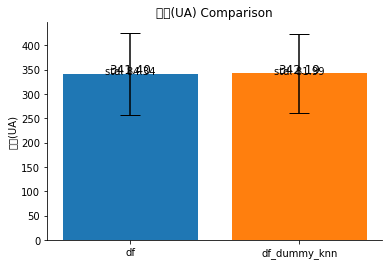

Glyph 22825 missing from current font.
Glyph 38376 missing from current font.
Glyph 20908 missing from current font.
Glyph 22825 missing from current font.
Glyph 38376 missing from current font.
Glyph 20908 missing from current font.


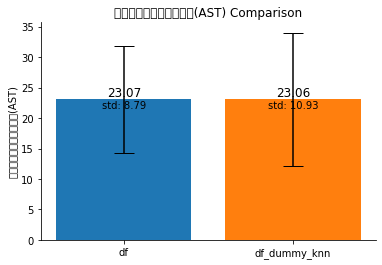

Glyph 24635 missing from current font.
Glyph 32966 missing from current font.
Glyph 22266 missing from current font.
Glyph 37255 missing from current font.
Glyph 24635 missing from current font.
Glyph 32966 missing from current font.
Glyph 22266 missing from current font.
Glyph 37255 missing from current font.


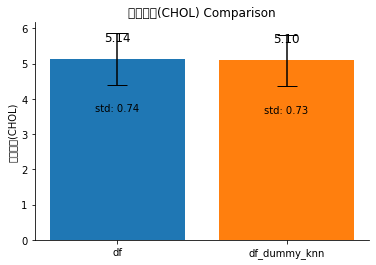

In [173]:
#compare train and testing data
# Calculate summary statistics
df_dummy_knn_stats = X_train.describe()
df_stats = X_test.describe()

# Define custom colors for bars
colors = ['#1f77b4', '#ff7f0e']
# Create bar plots of summary statistics
for col in df_stats.columns:
    fig, ax = plt.subplots()
    ax.bar(['df', 'df_dummy_knn'], [df_stats[col]['mean'], df_dummy_knn_stats[col]['mean']], yerr=[df_stats[col]['std'], df_dummy_knn_stats[col]['std']], capsize=10, color=colors)
    ax.set_ylabel(col)
    ax.set_title(f'{col} Comparison')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # Add labels for mean and std
    ax.text(0, df_stats[col]['mean']+0.5, f"{df_stats[col]['mean']:.2f}", ha='center', fontsize=12)
    ax.text(1, df_dummy_knn_stats[col]['mean']+0.5, f"{df_dummy_knn_stats[col]['mean']:.2f}", ha='center', fontsize=12)
    ax.text(0, df_stats[col]['mean']-1.5, f"std: {df_stats[col]['std']:.2f}", ha='center', fontsize=10)
    ax.text(1, df_dummy_knn_stats[col]['mean']-1.5, f"std: {df_dummy_knn_stats[col]['std']:.2f}", ha='center', fontsize=10)
    plt.show()

# Random Forest

In [38]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=50, random_state=0)

In [228]:
y_train.isna().sum()

0

In [229]:
# 拟合模型
clf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=50, random_state=0)

In [230]:
y_pred = clf.predict(X_test)
y_pred_quant = clf.predict_proba(X_test)[:, 1]
cm = confusion_matrix(y_test, y_pred)
cm

array([[483,  16],
       [ 67,   8]])

In [231]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

sensitivity = tp / (tp + fn)
print('Sensitivity : ', sensitivity )

specificity = tn / (fp + tn)
print('Specificity : ', specificity)

Sensitivity :  0.10666666666666667
Specificity :  0.9679358717434869


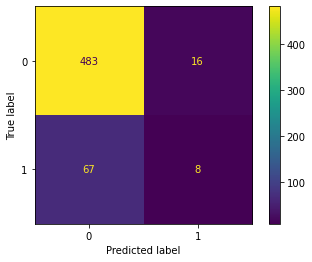

In [232]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(clf, X_test, y_test)

In [233]:
y_pred_quant

array([0.006     , 0.09765701, 0.23833333, 0.04666667, 0.20377193,
       0.        , 0.13759285, 0.06860806, 0.24733333, 0.64444444,
       0.04      , 0.06666667, 0.05285714, 0.04      , 0.        ,
       0.028     , 0.02      , 0.        , 0.        , 0.        ,
       0.01      , 0.08      , 0.19090837, 0.09690476, 0.15919658,
       0.045     , 0.13759285, 0.08166667, 0.18471429, 0.14990285,
       0.04607143, 0.        , 0.17928629, 0.40910514, 0.        ,
       0.17039554, 0.28666667, 0.06363636, 0.27333333, 0.        ,
       0.13759285, 0.07777273, 0.00812974, 0.13759285, 0.        ,
       0.20360317, 0.06      , 0.01285714, 0.        , 0.02666667,
       0.02      , 0.19090837, 0.36790476, 0.48166667, 0.02      ,
       0.13133333, 0.02      , 0.025     , 0.        , 0.35096825,
       0.78      , 0.04      , 0.02      , 0.04458333, 0.00761905,
       0.0575    , 0.13759285, 0.005     , 0.2447619 , 0.231     ,
       0.687     , 0.35      , 0.13759285, 0.388     , 0.15766

In [234]:
import numpy as np

y_test = y_test.astype(np.float64)
y_pred_quant = y_pred_quant.astype(np.float64)

In [235]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
y_test = encoder.fit_transform(y_test)

In [236]:
y_test

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,

In [237]:
print(y_test.shape, y_test.dtype)
print(y_pred_quant.shape, y_pred_quant.dtype)

(574,) int64
(574,) float64


In [238]:
print(np.unique(y_test))

[0 1]


In [239]:
print(np.unique(y_pred_quant))

[0.         0.00307692 0.00333333 0.00421053 0.005      0.00571429
 0.006      0.00666667 0.00738806 0.00761905 0.00812974 0.01
 0.011      0.01285714 0.01333333 0.015      0.01857143 0.02
 0.02022222 0.0225     0.02285714 0.02333333 0.024      0.025
 0.02514286 0.02619048 0.02666667 0.02748521 0.028      0.03
 0.03285714 0.03333333 0.03428571 0.035637   0.03585714 0.03666667
 0.03785714 0.03797619 0.03928571 0.04       0.0425     0.044
 0.04458333 0.045      0.04571429 0.04607143 0.04666667 0.04666667
 0.05       0.05285714 0.05333333 0.05333333 0.05404762 0.05623377
 0.05733333 0.0575     0.05852381 0.05904762 0.06       0.06166667
 0.06167832 0.06283552 0.06363636 0.064      0.06466667 0.06507692
 0.06551282 0.06622222 0.06666667 0.06685714 0.0675     0.068
 0.06833333 0.06860806 0.0689196  0.06904351 0.06909091 0.07
 0.07017647 0.07030303 0.07076923 0.07085714 0.07178161 0.07201145
 0.076      0.07709524 0.07777273 0.07785714 0.07892308 0.08
 0.08033333 0.08166667 0.08391004 0.0852

In [240]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_quant, pos_label=1)
auc_score = auc(fpr, tpr)

TypeError: 'numpy.float64' object is not callable

In [241]:
print(thresholds)

[1.92       0.92       0.90666667 0.80733333 0.75333333 0.65630252
 0.64444444 0.63752381 0.6268254  0.50633333 0.49446032 0.49033333
 0.48166667 0.47733333 0.47433333 0.45633333 0.45125469 0.44533333
 0.42566667 0.41819006 0.40910514 0.33133333 0.3205101  0.31666667
 0.31593851 0.304      0.30266667 0.29516667 0.29466667 0.29122222
 0.26902381 0.26315873 0.235      0.23416361 0.22966667 0.2285
 0.217      0.215      0.212      0.20448413 0.19833333 0.19681586
 0.19194872 0.19090837 0.19033333 0.18916883 0.18580303 0.18563492
 0.18387255 0.18235426 0.18142857 0.17928629 0.17622222 0.17600794
 0.17539033 0.17513889 0.17407692 0.17085714 0.17039554 0.16933333
 0.16333333 0.16211637 0.15766667 0.15704762 0.15333333 0.15166667
 0.14990285 0.14804329 0.14501704 0.14436652 0.14371429 0.14236075
 0.142      0.14107699 0.13759285 0.12966667 0.12748718 0.12666667
 0.12566667 0.12035294 0.12       0.11979494 0.11820513 0.1166048
 0.10593215 0.10520147 0.10056566 0.1        0.099      0.098
 0.09

In [242]:
print(auc_score)

0.6203740814963261


In [243]:
# compute equal error rate
res = 1
for idx, thr in enumerate(thresholds):
    if abs(tpr[idx] - (1 - fpr[idx])) < res:
        res = abs(tpr[idx] - (1 - fpr[idx]))
        eer_thr = thr
eer_thr

0.13759284500886193

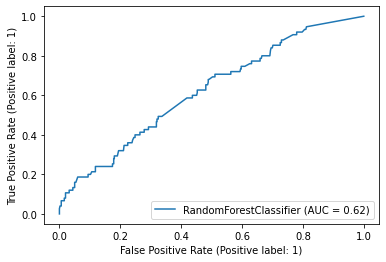

In [244]:
from sklearn.metrics import plot_roc_curve
plot_roc_curve(clf, X_test, y_test)
plt.show()

In [80]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler

ModuleNotFoundError: No module named 'imblearn'

In [ ]:
# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Resample the data to balance the classes
#ros = RandomOverSampler(random_state=42)
#X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

# Tune hyperparameters using cross-validation
params = {'n_estimators': [100, 200, 500],
          'max_depth': [2, 5, 10, 20],
          'min_samples_split': [2, 5, 10, 20]}
rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rf, params, scoring='roc_auc', cv=5)
grid_search.fit(X_train, y_train)
best_rf = grid_search.best_estimator_

# Fit the model on the training data
best_rf.fit(X_train, y_train)

# Make predictions on the test data
y_pred = best_rf.predict(X_test)

In [221]:
# Evaluate the performance of the model
auc = roc_auc_score(y_test, y_pred)
print('AUC:', auc)

AUC: 0.5393052772211089


# Logistic Regression

In [191]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    cross_val_score,
    RepeatedStratifiedKFold,
    StratifiedKFold,
)



In [192]:
# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [193]:
# Class weights.
w = [
    {0: 0.10, 1: 99.90},
    {0: 0.25, 1: 99.75},
    {0: 0.50, 1: 99.50},
    {0: 0.75, 1: 99.25},
    {0: 1.00, 1: 99.00},
    {
        0: 100
        * np.sum(y == 0)
        / (np.sum(y == 1) + np.sum(y == 0)),
        1: 100
        * np.sum(y == 1)
        / (np.sum(y == 0) + np.sum(y == 1)),
    },
]

# Inverse of regularization strength.
crange = np.arange(0.1, 1.0, 0.2)


In [194]:
# Hyperparameter grid.
hyperparam_grid = {
    "class_weight": w,
    "penalty": ["l2"], 
    "C": crange,
    "fit_intercept": [True, False],
}

In [195]:
# logistic model classifier.
lg = LogisticRegression(random_state=13)

# define evaluation procedure
grid = GridSearchCV(
    lg, hyperparam_grid, scoring="roc_auc", cv=10, n_jobs=-1, refit=True
)

In [250]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

In [251]:
# Assuming you have defined the necessary data and parameter grid for grid search

# Define the parameter grid
param_grid = {
    'solver': ['liblinear'],
    'penalty': ['l1', 'l2'],
    'C': [0.1, 1, 10]
    # Add other parameters and their values as needed
}

# Perform grid search
grid = GridSearchCV(LogisticRegression(), param_grid)
grid.fit(X_train, y_train)

# Access the best parameters
best_params = grid.best_params_

# Use the best parameters
best_fit_model = LogisticRegression(
    solver=best_params["solver"],
    penalty=best_params["penalty"],
    C=best_params["C"],
    # Add other necessary parameters
)


In [253]:
# fit it
best_fit_model.fit(X_train, y_train.astype("int32"))

LogisticRegression(C=0.1, penalty='l1', solver='liblinear')

              precision    recall  f1-score   support

           0       0.88      0.97      0.92       499
           1       0.33      0.11      0.16        75

    accuracy                           0.86       574
   macro avg       0.61      0.54      0.54       574
weighted avg       0.81      0.86      0.82       574



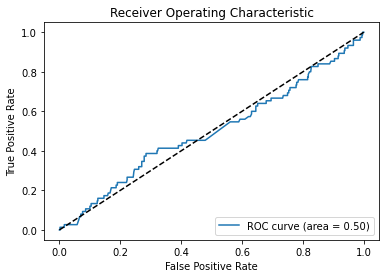

In [254]:
# Generate a classification report
print(classification_report(y_test, y_pred))

# Calculate the ROC curve and AUC score
y_pred_proba = best_fit_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
auc_score = roc_auc_score(y_test, y_pred_proba)

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

<AxesSubplot:>

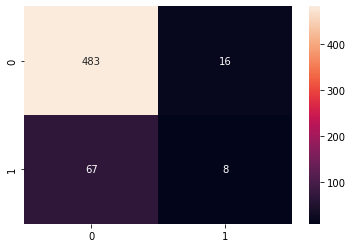

In [255]:
# Generate a confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d')

In [256]:
# Evaluate the performance of the model
auc = roc_auc_score(y_test, y_pred)
print('AUC:', auc)

AUC: 0.5373012692050768


# Support Vector Machine

In [210]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler

In [211]:
# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [212]:
# Train the SVM model
svm = SVC(kernel='linear', random_state=42)
svm.fit(X_train, y_train)

# Make predictions on the test data
y_pred = svm.predict(X_test)


In [213]:
# Evaluate the performance of the model
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))
print('Classification Report:\n', classification_report(y_test, y_pred))

Accuracy: 0.8693379790940766
Confusion Matrix:
 [[499   0]
 [ 75   0]]
Classification Report:
               precision    recall  f1-score   support

           0       0.87      1.00      0.93       499
           1       0.00      0.00      0.00        75

    accuracy                           0.87       574
   macro avg       0.43      0.50      0.47       574
weighted avg       0.76      0.87      0.81       574



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


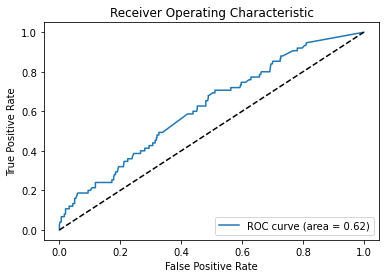

In [214]:
# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

<AxesSubplot:>

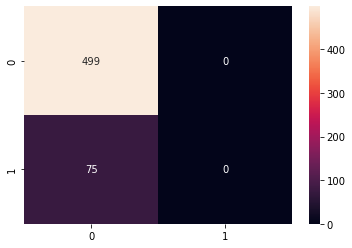

In [215]:
# Generate a confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d')


In [216]:
# Evaluate the performance of the model
auc = roc_auc_score(y_test, y_pred)
print('AUC:', auc)

AUC: 0.5


# XG Boost

In [217]:
#!pip install xgboost && 
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


In [218]:
# Train the XGBoost model
xgb_model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)
xgb_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = xgb_model.predict(X_test)

# Evaluate the performance of the model
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))
print('Classification Report:\n', classification_report(y_test, y_pred))

Accuracy: 0.8588850174216028
Confusion Matrix:
 [[485  14]
 [ 67   8]]
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.97      0.92       499
           1       0.36      0.11      0.16        75

    accuracy                           0.86       574
   macro avg       0.62      0.54      0.54       574
weighted avg       0.81      0.86      0.82       574



<AxesSubplot:>

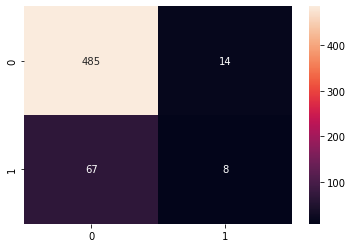

In [219]:
# Generate a confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d')

In [220]:
# Evaluate the performance of the model
auc = roc_auc_score(y_test, y_pred)
print('AUC:', auc)

AUC: 0.5393052772211089


# Cox regression

In [105]:
from lifelines import CoxPHFitter
from lifelines.datasets import load_rossi